## process C3D files into time series of marker data
- c3d file is a F x n x (x,y,z) dimension file, where F = number of frames, n = number of markers detected from acquisition
- labels are stored in reader.point_labels

In [43]:
import c3d 
import numpy as np
import matplotlib.pyplot as plt
import tools

In [44]:
# sampling rate is 200 Hz
# Open the .c3d file
with open('/Users/anqizhou/FastTrack/sampleData_11-15-2024/Sain_2019_11_15_DAp_GBMOV_T1_OFF_GNG_GAIT_001.c3d', 'rb') as f:
    reader = c3d.Reader(f)
    
    # Initialize data structures to store extracted data
    markers = []
    frame_numbers = []

    # Iterate over frames
    #for i, (points, analog) in enumerate(reader.read_frames()):
    for i, points in enumerate(reader.read_frames()):
        frame_numbers.append(i)
        markers.append(points[1][:,:3])  # Extract 3D positions (x, y, z), which are the first three values stored in the 1st tuple position
        #analog_data.append(analog)    # Extract analog signals (e.g., force plates)

# Convert to numpy arrays for easier manipulation
import numpy as np
markers = np.array(markers)        # Shape: (frames, markers, 3)
markers = np.transpose(markers, (1, 2, 0)) # change the shape so that it is (markers, 3, frames)

# create a dataset with label dictionary
data = {
    'marker_labels': reader.point_labels,
    'time_series_raw': tools.replace_zeros_with_neighbors_mean(markers,1),
    # to clean the data, let's assume that processes are linear over 3 timesteps (+1/-1 on each side)
    # or 
    # complete raw data
    #'time_series_raw': markers 
}

# data['marker_labels'] # test to retrieve marker labels from the data, note that labels that start with * are unlabled markers

# visualize the raw data

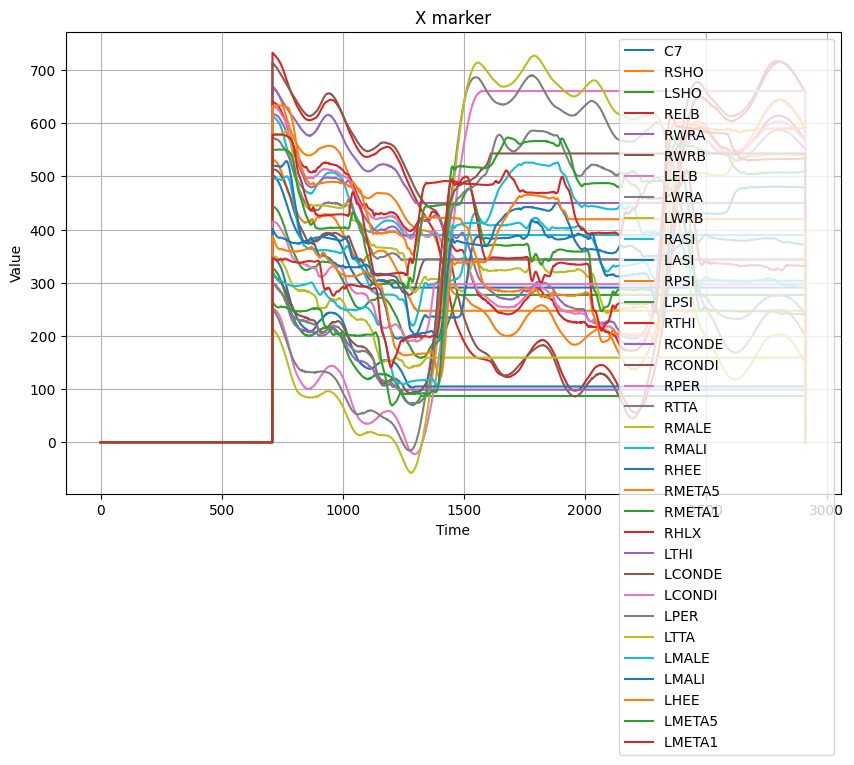

In [32]:
# x,y,z info for each marker i is stored as data['time_series_raw'][i][0], [i][1], or [i][2]

plt.figure(figsize=(10, 6))
for i in range(34): # there are a total of 34 known markers
#for i in range(len(data['time_series_raw'])): # total length includes markers that were dropped
    plt.plot(np.linspace(0, len(data['time_series_raw'][0][0]), num=len(data['time_series_raw'][0][0])), 
        data['time_series_raw'][i][0], label=data['marker_labels'][i])
plt.title('X marker')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

# Egocentric measurement
- let's find a central point between all markers, assuming that the markers are uniformly distributed
- convert the markers from space coordinates into vector coordinates from the center

In [45]:
center = np.mean(data['time_series_raw'], axis=0)

# transform marker data
ego = []
for i in range(len(reader.point_labels)):
    ego.append(data['time_series_raw'][i] - center) # compute euclidean distance
ego = {'time_series_centered': np.array(ego)}
data.update(ego)

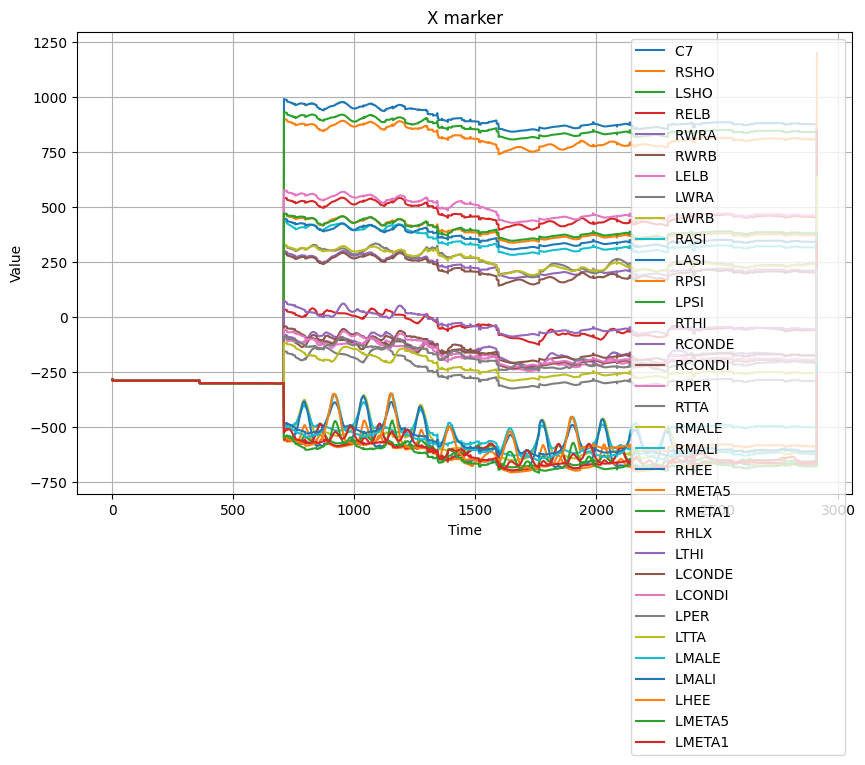

In [46]:
plt.figure(figsize=(10, 6))
for i in range(34): # there are a total of 34 known markers
#for i in range(len(data['time_series_raw'])): # total length includes markers that were dropped
    plt.plot(np.linspace(0, len(data['time_series_raw'][0][0]), num=len(data['time_series_raw'][0][0])), 
        data['time_series_centered'][i][2], label=data['marker_labels'][i])
plt.title('X marker')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()